In [157]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, roc_auc_score, recall_score,
    precision_score, f1_score, RocCurveDisplay)
from imblearn.metrics import specificity_score

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re



from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor



import matplotlib.pyplot as plt


In [158]:
df_selftext = pd.read_csv('../data/cleaned_selftext.csv')
df_notext = pd.read_csv('../data/cleaned_notext.csv')
df_selftext.head(2)

,subreddit,text
0,1,cost of moving bitcoin off an exchange i decid...
1,1,the new financial system is closer to fruition...


In [159]:
print(df_selftext.subreddit.value_counts())
df_notext.subreddit.value_counts()

1    2846
0     752
Name: subreddit, dtype: int64


1    7038
0    1981
Name: subreddit, dtype: int64

# Adding stop words to not make it too easy

In [160]:
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik'.split())


# Model

In [161]:
X = df_selftext.text
y = df_selftext.subreddit

In [162]:
y.value_counts(normalize=True)

1    0.790995
0    0.209005
Name: subreddit, dtype: float64

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [173]:
# Pipeline accepts multiple transformers, but only one vectorizer. See cgpt results:

'''The error message is caused by the fact that you are trying to fit two different vectorizers (TfidfVectorizer and CountVectorizer) 
in the same pipeline, but only providing one input (X_train) to the pipeline. This is causing the pipeline to raise an error as it doesn't 
know which vectorizer to apply to the input. 

You can fix this by either removing one of the vectorizers or providing separate inputs to the pipeline for each vectorizer.'''


nb_pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    #('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [198]:
nb_pipe_params = {
    'tvec__max_features': range(600,800,5),
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3),(2,3),(3,3)],
    'nb__alpha': [.005, .01, .25, .05, .075, .1]
    #'cvec__max_features': range(2500, 3500, 100),
    #'cvec__min_df': range(1,5),
    #'cvec__max_df': [i/100 for i in range(0, 100, 5)],
    #'cvec__ngram_range': [(1,1),(1, 2), (1,3)]
}

In [199]:
rs = RandomizedSearchCV(nb_pipe, 
                  nb_pipe_params, 
                    cv = 5) 

In [200]:
rs.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                             ('nb', MultinomialNB())]),
                   param_distributions={'nb__alpha': [0.005, 0.01, 0.25, 0.05,
                                                      0.075, 0.1],
                                        'tvec__max_features': range(600, 800, 5),
                                        'tvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3), (2, 3),
                                                              (3, 3)],
                                        'tvec__stop_words': [None, 'english']})

In [201]:
print(rs.score(X_train, y_train))
rs.score(X_test, y_test)

0.9329132690882135


0.9233333333333333

In [202]:
rs.best_params_

{'tvec__stop_words': 'english',
 'tvec__ngram_range': (1, 3),
 'tvec__max_features': 735,
 'nb__alpha': 0.005}

In [203]:
rs.score(X_test, y_test)

0.9233333333333333

In [204]:
preds = rs.predict(X_test)

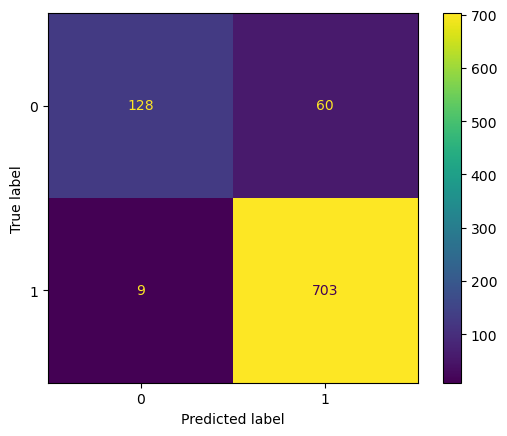

In [205]:
cm = confusion_matrix(y_test, preds)

display = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = rs.classes_)

display.plot();

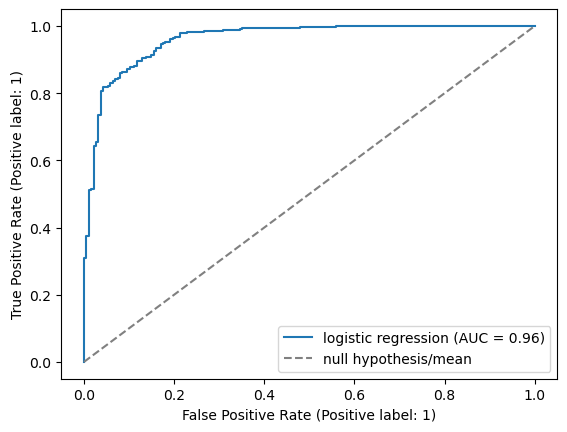

In [206]:
# Basic ROC

# cf ROC
# create an ax object
ax = plt.gca()

# use RocCurveDisplay for both estimators
RocCurveDisplay.from_estimator(rs, X_test, y_test, ax=ax, name='logistic regression')

# add 'worst case scenario' line
plt.plot([0,1], [0,1], label='null hypothesis/mean', linestyle='--', color='gray')

# necessary to label the baseline
plt.legend();

In [207]:
pred_df = pd.DataFrame(rs.predict_proba(X_test),columns=['ethereum', 'bitcoin'])

pred_df['true_values'] = y_test.values

pred_df.head()


,ethereum,bitcoin,true_values
0,0.677275,0.322725,1
1,0.072728,0.927272,1
2,0.072042,0.927958,1
3,0.994027,0.005973,0
4,0.058404,0.941596,0


In [208]:
#notes
def class_from_prob(probabilities, threshold):

    return [0 if prob < threshold else 1 for prob in probabilities]


In [209]:
threshold_list = [round(i*.01,2) for i in range(0,101,)]
speclist = []
senslist = []
f1list = []

for threshold in threshold_list:
    predicted_classes = class_from_prob(pred_df['bitcoin'], threshold)
    spec = specificity_score(y_test, predicted_classes)
    sens = recall_score(y_test, predicted_classes, pos_label=1)
    speclist.append(spec)
    senslist.append(sens)
    F1 = f1_score(y_test, predicted_classes)
    f1list.append(F1)

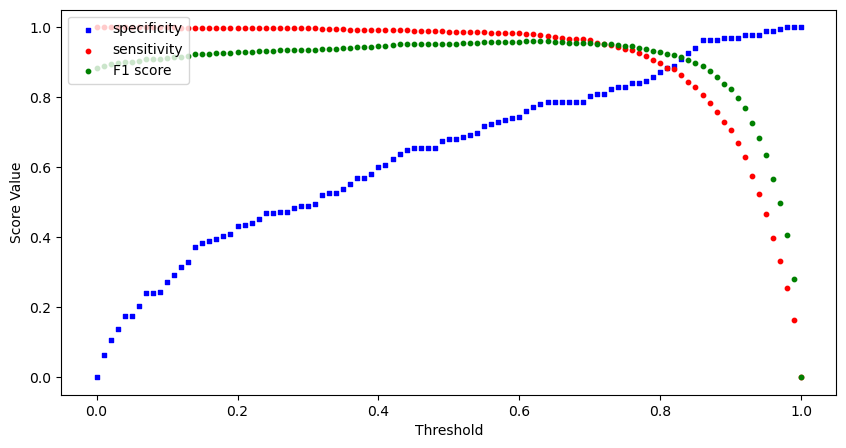

<Figure size 640x480 with 0 Axes>

In [210]:
%matplotlib inline
fig = plt.figure(figsize = (10,5));
ax1 = fig.add_subplot(111);

ax1.scatter(x = threshold_list, y = speclist, s=10, c='b', marker="s", label='specificity');
ax1.scatter(x = threshold_list,y = senslist, s=10, c='r', marker="o", label='sensitivity');
ax1.scatter(x = threshold_list,y = f1list, s=10, c='g', marker="o", label='F1 score');
plt.legend(loc='upper left')
plt.xlabel('Threshold');
plt.ylabel('Score Value');
plt.show();
plt.tight_layout();


In [185]:
# Create the model
level1_estimators = [
    ('nb', nb_pipe),
    ('knn_pipe', Pipeline([
        ('ss', StandardScaler()),
        ('knn', KNeighborsRegressor())
    ])),
    ('bag', BaggingRegressor())
]

stacked_model = StackingRegressor(estimators = level1_estimators,
                                 final_estimator = LogisticRegression())

In [186]:
stacked_model = RandomizedSearchCV(stacked_model, 
                  nb_pipe_params, 
                    cv = 5) 

In [ ]:
stacked_model.fit(X_train, y_train)

In [ ]:
print(stacked_model.score(X_train, y_train))
stacked_model.score(X_test,y_test)